In [3]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
# import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [4]:
# Load TSV files
variants = ['20H.Beta.V2_table', '20I.Alpha.V1_table', '20J.Gamma.V3_table', '21A.Delta_table', '21K.Omicron_table']
dfs = []

for variant in variants:
    df = pd.read_csv(f'{variant}.tsv', sep='\t')
    df['Variant'] = variant  # Add variant column
    df['first_seq'] = pd.to_datetime(df['first_seq'])  # Convert to datetime
    df['last_seq'] = pd.to_datetime(df['last_seq'])  
    dfs.append(df)

# Combine all data
data = pd.concat(dfs, ignore_index=True)

In [5]:
data.head()

,country,first_seq,num_seqs,last_seq,Variant
0,Zambia,2020-08-14,239,2021-06-04,20H.Beta.V2_table
1,South Africa,2020-08-18,6880,2022-01-07,20H.Beta.V2_table
2,Mozambique,2020-08-26,303,2021-07-15,20H.Beta.V2_table
3,United Arab Emirates,2020-08-28,42,2021-04-27,20H.Beta.V2_table
4,Botswana,2020-09-09,289,2021-08-10,20H.Beta.V2_table


# TIMESERIES GRAPH

In [6]:
# Aggregate sequences by date and variant
time_series_variants = data.groupby(['first_seq', 'Variant'])['num_seqs'].sum().unstack()


# Ensure the index is a continuous date range
full_date_range = pd.date_range(start=time_series_variants.index.min(), end=time_series_variants.index.max(), freq='D')
# Ensure 'first_seq' is a datetime index
# time_series_variants.index = pd.to_datetime(time_series_variants.index)
time_series_variants = time_series_variants.reindex(full_date_range).fillna(0)


# # Rename index to 'Date' for clarity
time_series_variants.index.name = 'Date'
time_series_variants.head()

time_series_variants.to_csv('time_series_variants.csv')


# Create a subplot figure with one row per variant
fig = sp.make_subplots(rows=len(variants), cols=1, shared_xaxes=True, vertical_spacing=0.02, subplot_titles=variants)

# Add a trace for each variant in its respective subplot
for i, variant in enumerate(variants):
    fig.add_trace(
        go.Scatter(x=time_series_variants.index, 
                   y=time_series_variants[variant], 
                   mode='lines', 
                   name=variant),
        row=i + 1, col=1
    )

# Update layout for better visualization
fig.update_layout(
    height=300 * len(variants),  # Adjust height based on the number of subplots
    title="Time Series of Variants",
    xaxis_title="Date",
    yaxis_title="Number of Sequences",
    showlegend=False,  # Disable legend to avoid repetition
    template="plotly"
)

fig.show()




NameError: name 'sp' is not defined

In [7]:
print(time_series_variants.columns)
weekly_data = time_series_variants.resample('W').sum()

# STL Decomposition for each variant
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, 
                       subplot_titles=("Trend (Log Scale)", "Seasonality (Log Scale)", "Residuals (Log Scale)"))

colors = ['blue', 'green', 'red', 'purple', 'orange']  # Distinct color scheme

for idx, variant in enumerate(weekly_data.columns):  # Exclude 'Month' and 'Season' columns
    stl = STL(weekly_data[variant].replace(0, 1), seasonal=13)  # Replace 0 with 1 to avoid log(0)
    res = stl.fit()

    # Add trend plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.trend,
        mode='lines',
        name=f"{variant} - Trend",
        line=dict(color=colors[idx % len(colors)])
    ), row=1, col=1)

    # Add seasonality plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.seasonal,
        mode='lines',
        name=f"{variant} - Seasonality",
        line=dict(color=colors[idx % len(colors)])
    ), row=2, col=1)

    # Add residuals plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.resid,  
        mode='lines',
        name=f"{variant} - Residuals",
        line=dict(color=colors[idx % len(colors)])
    ), row=3, col=1)

# Update layout for better visualization
fig.update_layout(
    title="STL Decomposition for Variants (Log Scale)",
    height=900,
    template="plotly_white"
)

# Separate legends for each subplot
fig.update_layout(
    showlegend=True,
    legend_tracegroupgap=300  # Adjust spacing between legends
)

fig.show()

Index(['20H.Beta.V2_table', '20I.Alpha.V1_table', '20J.Gamma.V3_table',
       '21A.Delta_table', '21K.Omicron_table'],
      dtype='object', name='Variant')


NameError: name 'sp' is not defined

In [8]:
# Ensure 'first_seq' is the index
time_series_variants.index.name = 'Date'

# Resample data to weekly frequency for smoother analysis
weekly_data = time_series_variants.resample('W').sum()

# # Plot raw data trends
# plt.figure(figsize=(12, 6))
# for variant in weekly_data.columns:
#     plt.plot(weekly_data[variant], label=variant)

# plt.title("Global Time Series of Variant Emergence (Weekly Aggregated)")
# plt.xlabel("Date")
# plt.ylabel("Number of Sequences")
# plt.legend(title="Variants", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

import plotly.subplots as sp

# STL Decomposition for each variant
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, 
                       subplot_titles=("Trend (Log Scale)", "Seasonality (Log Scale)", "Residuals (Log Scale)"))

colors = ['blue', 'green', 'red', 'purple', 'orange']  # Distinct color scheme

for idx, variant in enumerate(weekly_data.columns):  # Exclude 'Month' and 'Season' columns
    stl = STL(weekly_data[variant].replace(0, 1), seasonal=13)  # Replace 0 with 1 to avoid log(0)
    res = stl.fit()

    # Add trend plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.trend,
        mode='lines',
        name=f"{variant} - Trend",
        line=dict(color=colors[idx % len(colors)])
    ), row=1, col=1)

    # Add seasonality plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.seasonal,
        mode='lines',
        name=f"{variant} - Seasonality",
        line=dict(color=colors[idx % len(colors)])
    ), row=2, col=1)

    # Add residuals plot
    fig.add_trace(go.Scatter(
        x=weekly_data.index,
        y=res.resid,  
        mode='lines',
        name=f"{variant} - Residuals",
        line=dict(color=colors[idx % len(colors)])
    ), row=3, col=1)

# Update layout for better visualization
fig.update_layout(
    title="STL Decomposition for Variants (Log Scale)",
    height=900,
    template="plotly_white"
)

# Separate legends for each subplot
fig.update_layout(
    showlegend=True,
    legend_tracegroupgap=300  # Adjust spacing between legends
)

fig.show()

# # STL Decomposition for each variant
# fig = sp.make_subplots(rows=3, cols=5, shared_xaxes=True, 
#                        subplot_titles=[f"{variant} - {component}" for variant in weekly_data.columns for component in ["Trend", "Seasonality", "Residuals"]],
#                        vertical_spacing=0.1)

# colors = ['blue', 'green', 'red', 'purple', 'orange']  # Distinct color scheme

# for idx, variant in enumerate(weekly_data.columns):
#     stl = STL(weekly_data[variant], seasonal=13)
#     res = stl.fit()

#     # Add trend plot
#     fig.add_trace(go.Scatter(
#         x=weekly_data.index,
#         y=res.trend,
#         mode='lines',
#         name=f"{variant} - Trend",
#         line=dict(color=colors[idx % len(colors)])
#     ), row=1, col=idx + 1)

#     # Add seasonality plot
#     fig.add_trace(go.Scatter(
#         x=weekly_data.index,
#         y=res.seasonal,
#         mode='lines',
#         name=f"{variant} - Seasonality",
#         line=dict(color=colors[idx % len(colors)])
#     ), row=2, col=idx + 1)

#     # Add residuals plot
#     fig.add_trace(go.Scatter(
#         x=weekly_data.index,
#         y=res.resid,
#         mode='lines',
#         name=f"{variant} - Residuals",
#         line=dict(color=colors[idx % len(colors)])
#     ), row=3, col=idx + 1)

# # Update layout for better visualization
# fig.update_layout(
#     title="STL Decomposition for Variants (3x5 Subplots)",
#     height=1200,
#     template="plotly_white"
# )

# fig.show()


# Add 'Season' Column with months in brackets
weekly_data['Month'] = weekly_data.index.month
weekly_data['Season'] = weekly_data['Month'].apply(lambda x: 'Winter (Dec-Feb)' if x in [12, 1, 2] else
                                                           'Spring (Mar-May)' if x in [3, 4, 5] else
                                                           'Summer (Jun-Aug)' if x in [6, 7, 8] else
                                                           'Fall (Sep-Nov)')

# Aggregate by season
seasonal_totals = weekly_data.groupby('Season').sum()

# Seasonal Bar Plot using Plotly
fig = go.Figure()

for variant in seasonal_totals.columns:
    fig.add_trace(go.Bar(
        x=seasonal_totals.index,
        y=seasonal_totals[variant],
        name=variant
    ))

# Update layout for better visualization
fig.update_layout(
    barmode='stack',
    title="Variant Emergence by Season (Global)",
    xaxis_title="Season",
    yaxis_title="Total Sequences (Log Scale)",
    yaxis_type="log",
    template="plotly_white",
    legend_title="Variants"
)

fig.show()

# Filter data for India
india_data = data[data['country'] == 'India']

# Aggregate sequences by date and variant for India
india_time_series_variants = india_data.groupby(['first_seq', 'Variant'])['num_seqs'].sum().unstack()

# Ensure the index is a continuous date range
india_full_date_range = pd.date_range(start=india_time_series_variants.index.min(), 
                                      end=india_time_series_variants.index.max(), freq='D')
india_time_series_variants = india_time_series_variants.reindex(india_full_date_range).fillna(0)


# Rename index to 'Date' for clarity
india_time_series_variants.index.name = 'Date'

# Resample data to weekly frequency for smoother analysis
india_weekly_data = india_time_series_variants.resample('W').sum()

# Add 'Season' Column
india_weekly_data['Month'] = india_weekly_data.index.month
india_weekly_data['Season'] = india_weekly_data['Month'].apply(lambda x: 'Winter (Dec-Feb)' if x in [12, 1, 2] else
                                                               'Spring (Mar-May)' if x in [3, 4, 5] else
                                                               'Summer (Jun-Aug)' if x in [6, 7, 8] else
                                                               'Fall (Sep-Nov)')

# Aggregate by season
india_seasonal_totals = india_weekly_data.groupby('Season').sum()

# Seasonal Bar Plot for India
plt.figure(figsize=(12, 6))
india_seasonal_totals.drop(columns=['Month'], inplace=False).plot(kind='bar', stacked=True, colormap=plt.cm.get_cmap('viridis'), ax=plt.gca())  # Exclude 'Month' from the plot
plt.title("Variant Emergence by Season in India")
plt.xlabel("Season")
plt.ylabel("Total Sequences (Log Scale)")
plt.yscale('log')
plt.legend(title="Variants", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Heatmap of Variant Seasonality
plt.figure(figsize=(12, 6))
sns.heatmap(seasonal_totals.T, annot=True, cmap="coolwarm", fmt="g", linewidths=0.5)
plt.title("Seasonal Heatmap of Variant Emergence")
plt.xlabel("Season")
plt.ylabel("Variant")
plt.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [30]:
start_date = weekly_data.index.max()
print(start_date)

2022-05-29 00:00:00


In [118]:
# pd.date_range(start=start_date + pd.Timedelta(weeks=1), periods=forecast_steps, freq='W')

In [12]:
# print(weekly_data.columns)
# Forecast each variant
forecast_steps =  [6]

variant_type = ['21K.Omicron_table']

for forecast_steps_num in forecast_steps:
    for variant in variant_type:
        print(f"Processing ARIMA forecast for {variant}...")

        # Drop NaN values for fitting
        variant_data = weekly_data[variant].dropna()

        # Find optimal ARIMA parameters (p, d, q) using Auto-ARIMA
        auto_arima_model = pm.auto_arima(variant_data, seasonal=True, m=52,  # m=52 assumes yearly seasonality in weeks
                                        stepwise=True, suppress_warnings=True)

        # Fit the best ARIMA model
        arima_model = ARIMA(variant_data, order=auto_arima_model.order)
        arima_result = arima_model.fit()

        # Forecast future values
        forecast = arima_result.forecast(steps=forecast_steps_num)
        forecast.index = pd.date_range(start=variant_data.index.max() + pd.Timedelta(weeks=1), periods=forecast_steps_num, freq='W')
        forecast.index.name = 'Date'
        
        # save forecast to csv
        forecast.to_csv(f'{variant}_forecast_{forecast_steps_num}.csv')

        # # Plot historical data + forecast using Plotly
        # fig = sp.make_subplots(rows=1, cols=2, subplot_titles=[f"{variant} - Historical Data", f"{variant} - Forecast"])

        # # Add historical data trace
        # fig.add_trace(
        #     go.Scatter(
        #         x=variant_data.index,
        #         y=variant_data,
        #         mode='lines',
        #         name=f"{variant} - Historical Data"
        #     ),
        #     row=1, col=1
        # )

        # # Add forecast data trace
        # fig.add_trace(
        #     go.Scatter(
        #         x=forecast.index,
        #         y=forecast,
        #         mode='lines',
        #         name=f"{variant} - Forecast",
        #         line=dict(color='red')
        #     ),
        #     row=1, col=2
        # )

        # # Update layout for better visualization
        # fig.update_layout(
        #     title=f"ARIMA Forecast for {variant}",
        #     xaxis_title="Date",
        #     yaxis_title="Number of Sequences",
        #     template="plotly_white"
        # )

        # fig.show()


Processing ARIMA forecast for 21K.Omicron_table...


/Users/adyanshk/Desktop/Personal/courses/DM/disaster_encouragement/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/adyanshk/Desktop/Personal/courses/DM/disaster_encouragement/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/adyanshk/Desktop/Personal/courses/DM/disaster_encouragement/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/adyanshk/Desktop/Personal/courses/DM/disaster_encouragement/.venv/lib/python3.9/site-packages/pmdarima/arima/utils.py:117: UserWarning:

Appropriate D value may not have been reached; length of seasonally-differenced array (42) is shorter than m (52). Using D=1

/Users/

In [11]:
print(variant_data)

Date
2020-08-16     239.0
2020-08-23    6880.0
2020-08-30     345.0
2020-09-06       0.0
2020-09-13     289.0
               ...  
2022-05-01       0.0
2022-05-08       0.0
2022-05-15       0.0
2022-05-22       0.0
2022-05-29       0.0
Freq: W-SUN, Name: 20H.Beta.V2_table, Length: 94, dtype: float64


In [12]:
print(forecast)

Date
2022-06-05    18.971018
2022-06-12    26.239491
2022-06-19    29.024301
2022-06-26    30.091261
2022-07-03    30.500052
2022-07-10    30.656674
2022-07-17    30.716681
2022-07-24    30.739672
2022-07-31    30.748481
2022-08-07    30.751856
2022-08-14    30.753149
2022-08-21    30.753644
2022-08-28    30.753834
2022-09-04    30.753907
2022-09-11    30.753935
2022-09-18    30.753945
2022-09-25    30.753950
2022-10-02    30.753951
2022-10-09    30.753952
2022-10-16    30.753952
2022-10-23    30.753952
2022-10-30    30.753952
2022-11-06    30.753952
2022-11-13    30.753952
Freq: W-SUN, Name: predicted_mean, dtype: float64


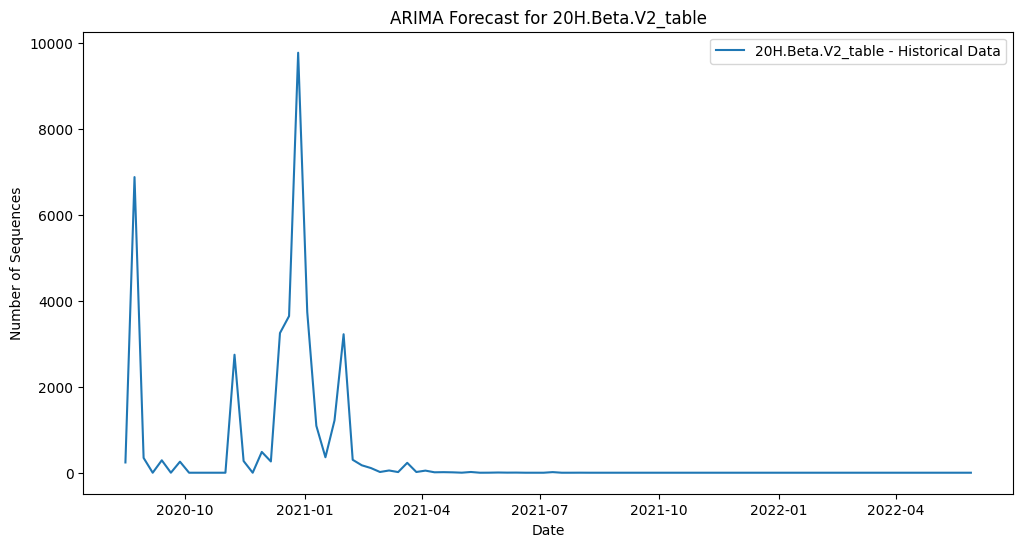

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(variant_data, label=f"{variant} - Historical Data")
# plt.plot(forecast.to_numpy(), label=f"{variant} - Forecast", color='red')
plt.title(f"ARIMA Forecast for {variant}")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.legend()
plt.show()

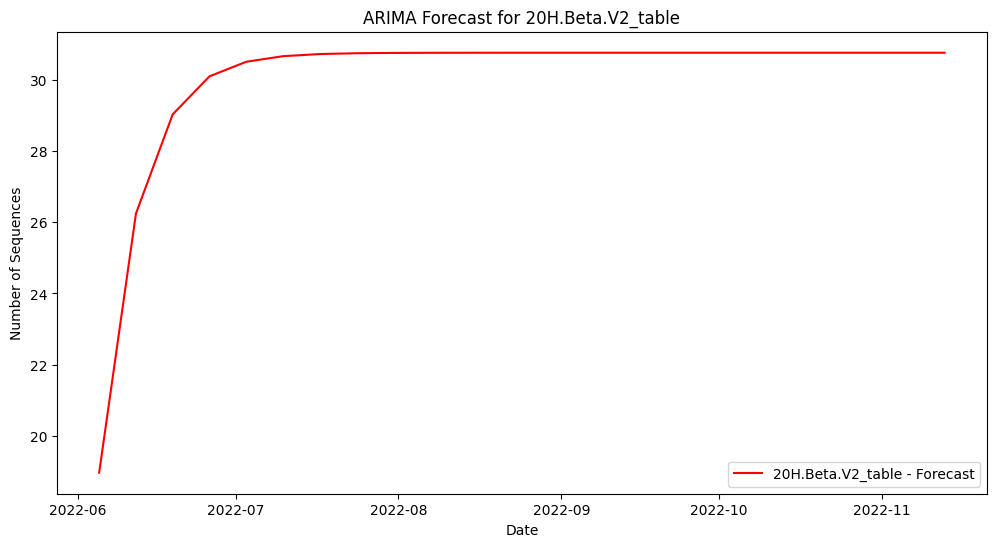

In [14]:
plt.figure(figsize=(12, 6))
# plt.plot(variant_data, label=f"{variant} - Historical Data")
plt.plot(forecast, label=f"{variant} - Forecast", color='red')
plt.title(f"ARIMA Forecast for {variant}")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.legend()
plt.show()

In [2]:
# # STL Decomposition
# stl = STL(time_series, seasonal=13)  # Seasonality can be adjusted
# res = stl.fit()

# # Plot decomposition
# fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
# axs[0].plot(res.trend, label="Trend")
# axs[0].set_title("Trend")
# axs[1].plot(res.seasonal, label="Seasonality")
# axs[1].set_title("Seasonality")
# axs[2].plot(res.resid, label="Residuals")
# axs[2].set_title("Residuals")
# for ax in axs:
#     ax.legend()
# plt.show()

In [55]:
# # ADF Test for Stationarity
# adf_result = adfuller(time_series.dropna())
# print(f"ADF Statistic: {adf_result[0]}")
# print(f"P-Value: {adf_result[1]}")

# # If non-stationary, difference the data
# if adf_result[1] > 0.05:
#     time_series = time_series.diff().dropna()

# # Fit ARIMA Model
# p, d, q = 2, 1, 2  # Adjust based on ACF/PACF analysis
# model = ARIMA(time_series, order=(p, d, q))
# model_fit = model.fit()

# # Forecast Future Values
# forecast_steps = 30  # Forecast for next 30 days
# forecast = model_fit.forecast(steps=forecast_steps)

# # Plot Forecast
# plt.figure(figsize=(12, 5))
# plt.plot(time_series, label="Observed")
# plt.plot(pd.date_range(time_series.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label="Forecast", color='red')
# plt.title("ARIMA Forecast for Variant Emergence")
# plt.xlabel("Date")
# plt.ylabel("Number of Sequences")
# plt.legend()
# plt.show()